In [0]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np


In [0]:


df = pd.read_csv('Cell viability and extrusion dataset V1.csv')
display(df.columns)

if 'Viability_at_time_of_observation_(%)' in df.columns:
    df['Acceptable'] = np.where(df['Viability_at_time_of_observation_(%)'] > 70, 1, 0)

    X = df.drop(columns=['Viability_at_time_of_observation_(%)', 'Acceptable'])  # Dropping target columns for features
    y_regression = df['Viability_at_time_of_observation_(%)']
    y_classification = df['Acceptable']
    
    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()
    #Tutorial two! 
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])
    #Build dataset for training and test 0.85/0.15 ratio
    #Copy from tutorial 2
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.15, random_state=42)
    X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_classification, test_size=0.15, random_state=42)
    
    X_train_reg = preprocessor.fit_transform(X_train_reg)
    X_test_reg = preprocessor.transform(X_test_reg)
    X_train_cls = preprocessor.fit_transform(X_train_cls)
    X_test_cls = preprocessor.transform(X_test_cls)
    
    X_train_reg_torch = torch.tensor(X_train_reg.toarray(), dtype=torch.float32) if hasattr(X_train_reg, 'toarray') else torch.tensor(X_train_reg, dtype=torch.float32)
    y_train_reg_torch = torch.tensor(y_train_reg.values, dtype=torch.float32).view(-1, 1)
    X_test_reg_torch = torch.tensor(X_test_reg.toarray(), dtype=torch.float32) if hasattr(X_test_reg, 'toarray') else torch.tensor(X_test_reg, dtype=torch.float32)
    y_test_reg_torch = torch.tensor(y_test_reg.values, dtype=torch.float32).view(-1, 1)

    X_train_cls_torch = torch.tensor(X_train_cls.toarray(), dtype=torch.float32) if hasattr(X_train_cls, 'toarray') else torch.tensor(X_train_cls, dtype=torch.float32)
    y_train_cls_torch = torch.tensor(y_train_cls.values, dtype=torch.long)
    X_test_cls_torch = torch.tensor(X_test_cls.toarray(), dtype=torch.float32) if hasattr(X_test_cls, 'toarray') else torch.tensor(X_test_cls, dtype=torch.float32)
    y_test_cls_torch = torch.tensor(y_test_cls.values, dtype=torch.long)

    print("Data preprocessing completed successfully.")
else:
    print("Error: 'Viability_at_time_of_observation_(%)' column not found in the dataset.")


Index(['Reference', 'DOI', 'Final_Alginate_Conc_(%w/v)',
       'Final_Gelatin_Conc_(%w/v)', 'Final_GelMA_Conc_(%w/v)',
       'Final_Hyaluronic_Acid_Conc_(%w/v)', 'Final_MeHA_Conc_(%w/v)',
       'Final_NorHA_Conc_(%w/v)', 'Final_Fibroin/Fibrinogen_Conc_(%w/v)',
       'Final_P127_Conc_(%w/v)', 'Final_Collagen_Conc_(%w/v)',
       'Final_Chitosan_Conc_(%w/v)', 'Final_CS-AEMA_Conc_(%w/v)',
       'Final_TCP_Conc_(%w/v)', 'Final_Gellan_Conc_(%w/v)',
       'Final_Nano/Methycellulose_Conc_(%w/v)', 'Final_PEGTA_Conc_(%w/v)',
       'Final_PEGMA_Conc_(%w/v)', 'Final_PEGDA_Conc_(%w/v)',
       'Final_Agarose_Conc_(%w/v)', 'CaCl2_Conc_(mM)', 'NaCl2_Conc_(mM)',
       'BaCl2_Conc_(mM)', 'SrCl2_Conc_(mM)',
       'Physical_Crosslinking_Durantion_(s)', 'Photocrosslinking_Duration_(s)',
       'Extrusion_Pressure (kPa)', 'Extrusion_Rate_Lengthwise_(mm/s)',
       'Extrusion_Rate_Volume-wise_(mL/s)', 'Nozzle_Movement_Speed_(mm/s)',
       'Inner_Nozzle_Outer_Diameter_(µm)', 'Outer_Nozzle_Inner_Di

Data preprocessing completed successfully.


In [0]:
class RegressionNN(nn.Module):
    def __init__(self, input_size, activations):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.activations = activations

    def forward(self, x):
        x = self.activations[0](self.fc1(x))
        x = self.activations[1](self.fc2(x))
        x = self.fc3(x)
        return x

class ClassificationNN(nn.Module):
    def __init__(self, input_size, activations):
        super(ClassificationNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2) 
        self.activations = activations

    def forward(self, x):
        x = self.activations[0](self.fc1(x))
        x = self.activations[1](self.fc2(x))
        x = self.fc3(x)
        return x


In [0]:
# Import metrics for classification
from sklearn.metrics import mean_squared_error, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim

# Enhanced Regression Model Training with Performance Reporting
def train_regression_model(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=100):
    # Handle NaN values
    X_train = torch.nan_to_num(X_train, nan=0.0)
    y_train = torch.nan_to_num(y_train, nan=0.0)
    X_test = torch.nan_to_num(X_test, nan=0.0)
    y_test = torch.nan_to_num(y_test, nan=0.0)
    
    model.train()
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Test performance
        model.eval()
        with torch.no_grad():
            test_output = model(X_test)
            test_loss = criterion(test_output, y_test)
            test_losses.append(test_loss.item())
        model.train()

    # Report performance for training and testing
    train_mse = mean_squared_error(y_train.cpu().numpy(), output.detach().cpu().numpy())
    test_mse = mean_squared_error(y_test.cpu().numpy(), test_output.cpu().numpy())
    print(f"Final Training MSE: {train_mse:.4f} | Final Testing MSE: {test_mse:.4f}")

    return train_losses, test_losses

# Enhanced Classification Model Training with Performance Reporting
def train_classification_model(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=100):
    # Handle NaN values
    X_train = torch.nan_to_num(X_train, nan=0.0)
    y_train = torch.nan_to_num(y_train, nan=0.0)
    X_test = torch.nan_to_num(X_test, nan=0.0)
    y_test = torch.nan_to_num(y_test, nan=0.0)
    
    model.train()
    train_accuracies = []
    test_accuracies = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        # Calculate accuracy on training data
        _, predicted = torch.max(output, 1)
        train_accuracy = (predicted == y_train).sum().item() / len(y_train)
        train_accuracies.append(train_accuracy)

        # Test performance
        model.eval()
        with torch.no_grad():
            test_output = model(X_test)
            _, test_predicted = torch.max(test_output, 1)
            test_accuracy = (test_predicted == y_test).sum().item() / len(y_test)
            test_accuracies.append(test_accuracy)
        model.train()

    # Report performance for training and testing
    train_accuracy = accuracy_score(y_train.cpu(), predicted.cpu())
    train_precision = precision_score(y_train.cpu(), predicted.cpu(), average='binary')
    train_recall = recall_score(y_train.cpu(), predicted.cpu(), average='binary')
    test_accuracy = accuracy_score(y_test.cpu(), test_predicted.cpu())
    test_precision = precision_score(y_test.cpu(), test_predicted.cpu(), average='binary')
    test_recall = recall_score(y_test.cpu(), test_predicted.cpu(), average='binary')

    print(f"Final Training Accuracy: {train_accuracy:.4f} | Precision: {train_precision:.4f} | Recall: {train_recall:.4f}")
    print(f"Final Testing Accuracy: {test_accuracy:.4f} | Precision: {test_precision:.4f} | Recall: {test_recall:.4f}")

    return train_accuracies, test_accuracies

# Instantiate models
regression_model = RegressionNN(input_size=X_train_reg_torch.shape[1], activations=[nn.ReLU(), nn.ReLU()])
classification_model = ClassificationNN(input_size=X_train_cls_torch.shape[1], activations=[nn.ReLU(), nn.ReLU()])

# Define loss functions and optimizers
criterion_reg = nn.MSELoss()
optimizer_reg = optim.Adam(regression_model.parameters(), lr=0.01)
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(classification_model.parameters(), lr=0.01)

# Train the models
train_losses_reg, test_losses_reg = train_regression_model(
    regression_model, criterion_reg, optimizer_reg, X_train_reg_torch, y_train_reg_torch, X_test_reg_torch, y_test_reg_torch)

train_accuracies_cls, test_accuracies_cls = train_classification_model(
    classification_model, criterion_cls, optimizer_cls, X_train_cls_torch, y_train_cls_torch, X_test_cls_torch, y_test_cls_torch)

print("Regression model training and testing complete.")
print("Classification model training and testing complete.")

Final Training MSE: 37.3655 | Final Testing MSE: 137.9754
Final Training Accuracy: 0.9905 | Precision: 0.9899 | Recall: 0.9974
Final Testing Accuracy: 0.8925 | Precision: 0.9701 | Recall: 0.8904
Regression model training and testing complete.
Classification model training and testing complete.


that's good


Training with ReLU
NaN values detected, filling with specified fill value.
NaN values detected, filling with specified fill value.
Training with Tanh
NaN values detected, filling with specified fill value.
NaN values detected, filling with specified fill value.
Training with Sigmoid
NaN values detected, filling with specified fill value.
NaN values detected, filling with specified fill value.


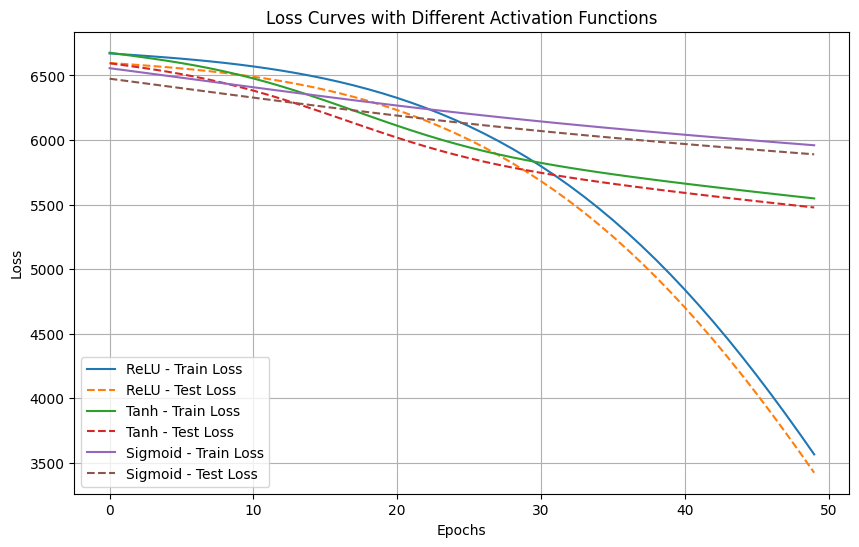

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score

# Improved check_and_fill_nans function
def check_and_fill_nans(tensor, fill_value=0.0):
    if torch.isnan(tensor).any():
        print("NaN values detected, filling with specified fill value.")
        tensor = torch.nan_to_num(tensor, nan=fill_value)
    return tensor

# Training and evaluation function with logging
def train_and_evaluate_with_logging(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=50, task="regression"):
    train_losses = []
    test_losses = []
    
    # Check and fill NaNs in input data
    X_train = check_and_fill_nans(X_train)
    y_train = check_and_fill_nans(y_train)
    X_test = check_and_fill_nans(X_test)
    y_test = check_and_fill_nans(y_test)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        
        # Check for NaNs in outputs
        if torch.isnan(outputs).any():
            print("NaN values found in model outputs during training! Exiting training.")
            return train_losses, test_losses
        
        # Compute training loss and backpropagate
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            predictions = model(X_test)
            
            if torch.isnan(predictions).any():
                print("NaN values found in predictions! Skipping this epoch's test loss calculation.")
                test_losses.append(np.nan)
                continue 
            
            # Compute test loss
            if task == "regression":
                test_loss = mean_squared_error(y_test.cpu().numpy(), predictions.cpu().numpy())
            else:
                predictions = torch.argmax(predictions, axis=1)
                test_loss = 1 - accuracy_score(y_test.cpu().numpy(), predictions.cpu().numpy())
            test_losses.append(test_loss)

    return train_losses, test_losses

# Plotting function to visualize the results
def plot_loss_curves(train_losses, test_losses, activations):
    plt.figure(figsize=(10, 6))
    
    for i, activation in enumerate(activations):
        plt.plot(train_losses[i], label=f"{activation} - Train Loss")
        plt.plot(test_losses[i], label=f"{activation} - Test Loss", linestyle="--")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curves with Different Activation Functions")
    plt.legend()
    plt.grid(True)
    plt.show()

# Define activation functions
activation_functions = {
    "ReLU": nn.ReLU(),
    "Tanh": nn.Tanh(),
    "Sigmoid": nn.Sigmoid()
}

train_losses_all = []
test_losses_all = []
activation_names = []

for name, activation in activation_functions.items():
    print(f"Training with {name}")
    
    # Create and train the regression model
    model_reg = RegressionNN(input_size=X_train_reg_torch.shape[1], activations=[activation, activation])
    criterion_reg = nn.MSELoss()
    optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001)
    
    # Train and evaluate the model
    train_losses, test_losses = train_and_evaluate_with_logging(
        model_reg, criterion_reg, optimizer_reg,
        X_train_reg_torch, y_train_reg_torch, X_test_reg_torch, y_test_reg_torch,
        task="regression"
    )
    
    # Store the results
    train_losses_all.append(train_losses)
    test_losses_all.append(test_losses)
    activation_names.append(name)

# Plot all loss curves
plot_loss_curves(train_losses_all, test_losses_all, activation_names)


Training with ReLU
NaN values detected, filling with specified fill value.
NaN values detected, filling with specified fill value.
Training with Tanh
NaN values detected, filling with specified fill value.
NaN values detected, filling with specified fill value.
Training with Sigmoid
NaN values detected, filling with specified fill value.
NaN values detected, filling with specified fill value.


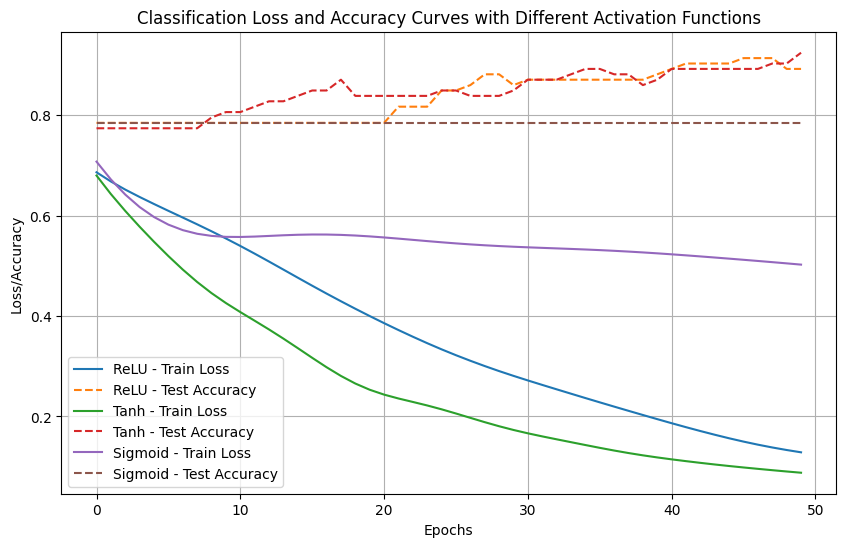

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Training and evaluation function for classification with logging
def train_and_evaluate_classification_with_logging(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=50):
    train_losses = []
    test_accuracies = []
    
    # Check and fill NaNs in input data
    X_train = check_and_fill_nans(X_train)
    y_train = check_and_fill_nans(y_train)
    X_test = check_and_fill_nans(X_test)
    y_test = check_and_fill_nans(y_test)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        
        # Check for NaNs in outputs
        if torch.isnan(outputs).any():
            print("NaN values found in model outputs during training! Exiting training.")
            return train_losses, test_accuracies
        
        # Compute training loss and backpropagate
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            predictions = model(X_test)
            
            if torch.isnan(predictions).any():
                print("NaN values found in predictions! Skipping this epoch's test accuracy calculation.")
                test_accuracies.append(np.nan)
                continue 
            
            # Calculate accuracy
            predicted_classes = torch.argmax(predictions, axis=1)
            accuracy = accuracy_score(y_test.cpu().numpy(), predicted_classes.cpu().numpy())
            test_accuracies.append(accuracy)

    return train_losses, test_accuracies

# Plotting function to visualize classification loss and accuracy curves
def plot_classification_results(train_losses, test_accuracies, activations):
    plt.figure(figsize=(10, 6))
    
    for i, activation in enumerate(activations):
        plt.plot(train_losses[i], label=f"{activation} - Train Loss")
        plt.plot(test_accuracies[i], label=f"{activation} - Test Accuracy", linestyle="--")

    plt.xlabel("Epochs")
    plt.ylabel("Loss/Accuracy")
    plt.title("Classification Loss and Accuracy Curves with Different Activation Functions")
    plt.legend()
    plt.grid(True)
    plt.show()

# Define activation functions
activation_functions = {
    "ReLU": nn.ReLU(),
    "Tanh": nn.Tanh(),
    "Sigmoid": nn.Sigmoid()
}

train_losses_all = []
test_accuracies_all = []
activation_names = []

for name, activation in activation_functions.items():
    print(f"Training with {name}")
    
    # Create and train the classification model
    model_cls = ClassificationNN(input_size=X_train_cls_torch.shape[1], activations=[activation, activation])
    criterion_cls = nn.CrossEntropyLoss()
    optimizer_cls = optim.Adam(model_cls.parameters(), lr=0.001)
    
    # Train and evaluate the model
    train_losses, test_accuracies = train_and_evaluate_classification_with_logging(
        model_cls, criterion_cls, optimizer_cls,
        X_train_cls_torch, y_train_cls_torch, X_test_cls_torch, y_test_cls_torch
    )
    
    # Store the results
    train_losses_all.append(train_losses)
    test_accuracies_all.append(test_accuracies)
    activation_names.append(name)

# Plot all loss and accuracy curves for classification
plot_classification_results(train_losses_all, test_accuracies_all, activation_names)


Finished training with lr=0.001, momentum=0
Finished training with lr=0.001, momentum=0.9
Finished training with lr=0.01, momentum=0
Finished training with lr=0.01, momentum=0.9
Finished training with lr=0.1, momentum=0
Finished training with lr=0.1, momentum=0.9
Finished training with lr=0.001, momentum=0
Finished training with lr=0.001, momentum=0.9
Finished training with lr=0.01, momentum=0
Finished training with lr=0.01, momentum=0.9
Finished training with lr=0.1, momentum=0
Finished training with lr=0.1, momentum=0.9


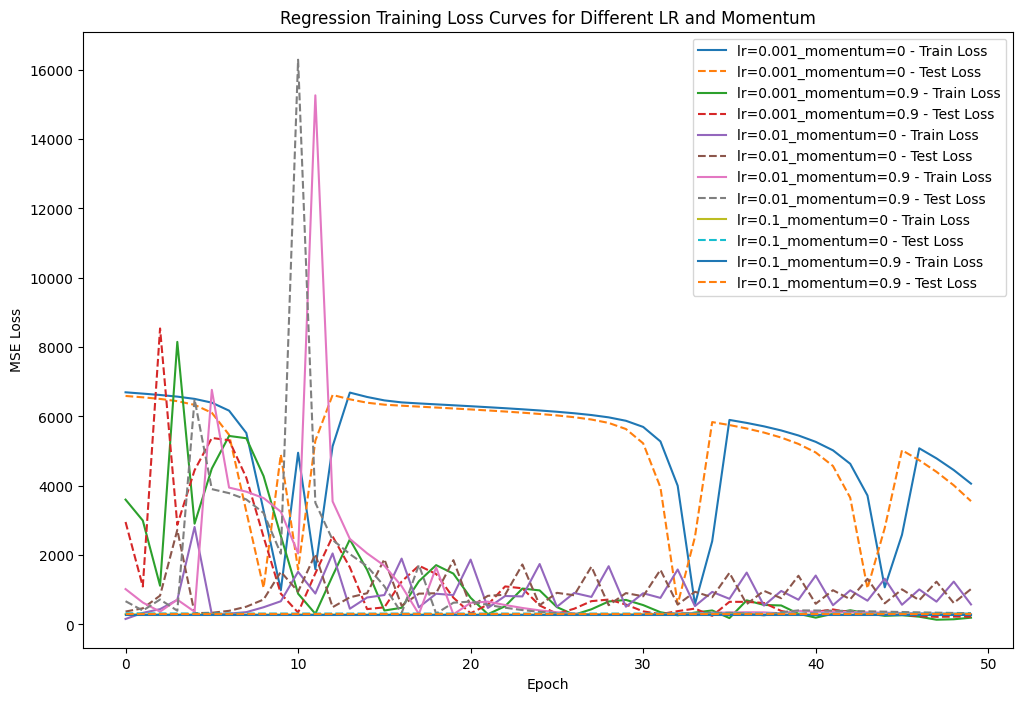

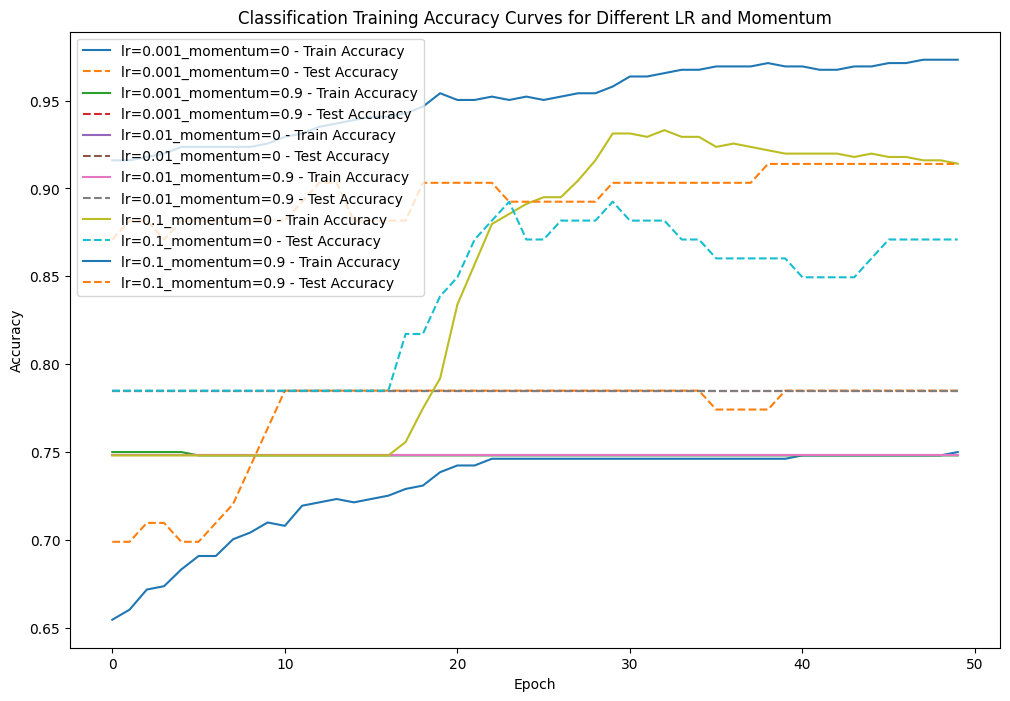

In [0]:
import matplotlib.pyplot as plt

# Enhanced Regression Training with Multiple Learning Rates and Momentum
def train_regression_with_lr_momentum(model, X_train, y_train, X_test, y_test, learning_rates=[1e-3, 1e-2, 1e-1], epochs=50):
    results = {}
    X_train = torch.nan_to_num(X_train, nan=0.0)
    y_train = torch.nan_to_num(y_train, nan=0.0)
    X_test = torch.nan_to_num(X_test, nan=0.0)
    y_test = torch.nan_to_num(y_test, nan=0.0)
    for lr in learning_rates:
        for momentum in [0, 0.9]:  # Test with and without momentum
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
            criterion = nn.MSELoss()
            
            train_losses = []
            test_losses = []
            
            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()
                
                # Forward pass
                output = model(X_train)
                loss = criterion(output, y_train)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                train_losses.append(loss.item())
                
                # Test performance at this epoch
                model.eval()
                with torch.no_grad():
                    test_output = model(X_test)
                    test_loss = criterion(test_output, y_test)
                    test_losses.append(test_loss.item())
                
            # Store the training loss curves for plotting
            results[f'lr={lr}_momentum={momentum}'] = {
                'train_loss': train_losses,
                'test_loss': test_losses
            }
            
            print(f"Finished training with lr={lr}, momentum={momentum}")
    
    return results

# Enhanced Classification Training with Multiple Learning Rates and Momentum
def train_classification_with_lr_momentum(model, X_train, y_train, X_test, y_test, learning_rates=[1e-3, 1e-2, 1e-1], epochs=50):
    results = {}
    X_train = torch.nan_to_num(X_train, nan=0.0)
    y_train = torch.nan_to_num(y_train, nan=0.0)
    X_test = torch.nan_to_num(X_test, nan=0.0)
    y_test = torch.nan_to_num(y_test, nan=0.0)
    for lr in learning_rates:
        for momentum in [0, 0.9]:  # Test with and without momentum
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
            criterion = nn.CrossEntropyLoss()
            
            train_accuracies = []
            test_accuracies = []
            
            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()
                
                # Forward pass
                output = model(X_train)
                loss = criterion(output, y_train)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                # Calculate accuracy on training data
                _, predicted = torch.max(output, 1)
                train_accuracy = (predicted == y_train).sum().item() / len(y_train)
                train_accuracies.append(train_accuracy)
                
                # Test performance
                model.eval()
                with torch.no_grad():
                    test_output = model(X_test)
                    _, test_predicted = torch.max(test_output, 1)
                    test_accuracy = (test_predicted == y_test).sum().item() / len(y_test)
                    test_accuracies.append(test_accuracy)
                
            # Store the training accuracy curves for plotting
            results[f'lr={lr}_momentum={momentum}'] = {
                'train_accuracy': train_accuracies,
                'test_accuracy': test_accuracies
            }
            
            print(f"Finished training with lr={lr}, momentum={momentum}")
    
    return results

# Function to plot results for regression losses
def plot_regression_results(results):
    plt.figure(figsize=(12, 8))
    for key, value in results.items():
        plt.plot(value['train_loss'], label=f'{key} - Train Loss')
        plt.plot(value['test_loss'], linestyle='--', label=f'{key} - Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Regression Training Loss Curves for Different LR and Momentum')
    plt.legend()
    plt.show()

# Function to plot results for classification accuracies
def plot_classification_results(results):
    plt.figure(figsize=(12, 8))
    for key, value in results.items():
        plt.plot(value['train_accuracy'], label=f'{key} - Train Accuracy')
        plt.plot(value['test_accuracy'], linestyle='--', label=f'{key} - Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Classification Training Accuracy Curves for Different LR and Momentum')
    plt.legend()
    plt.show()

# Instantiate models
regression_model = RegressionNN(input_size=X_train_reg_torch.shape[1], activations=[nn.ReLU(), nn.ReLU()])
classification_model = ClassificationNN(input_size=X_train_cls_torch.shape[1], activations=[nn.ReLU(), nn.ReLU()])

# Train and evaluate regression model with various learning rates and momentum
regression_results = train_regression_with_lr_momentum(
    regression_model, X_train_reg_torch, y_train_reg_torch, X_test_reg_torch, y_test_reg_torch
)

# Train and evaluate classification model with various learning rates and momentum
classification_results = train_classification_with_lr_momentum(
    classification_model, X_train_cls_torch, y_train_cls_torch, X_test_cls_torch, y_test_cls_torch
)

# Plot results
plot_regression_results(regression_results)
plot_classification_results(classification_results)


Finished 10-fold CV with lr=0.001, momentum=0
Finished 10-fold CV with lr=0.001, momentum=0.9
Finished 10-fold CV with lr=0.01, momentum=0
Finished 10-fold CV with lr=0.01, momentum=0.9
Finished 10-fold CV with lr=0.1, momentum=0
Finished 10-fold CV with lr=0.1, momentum=0.9


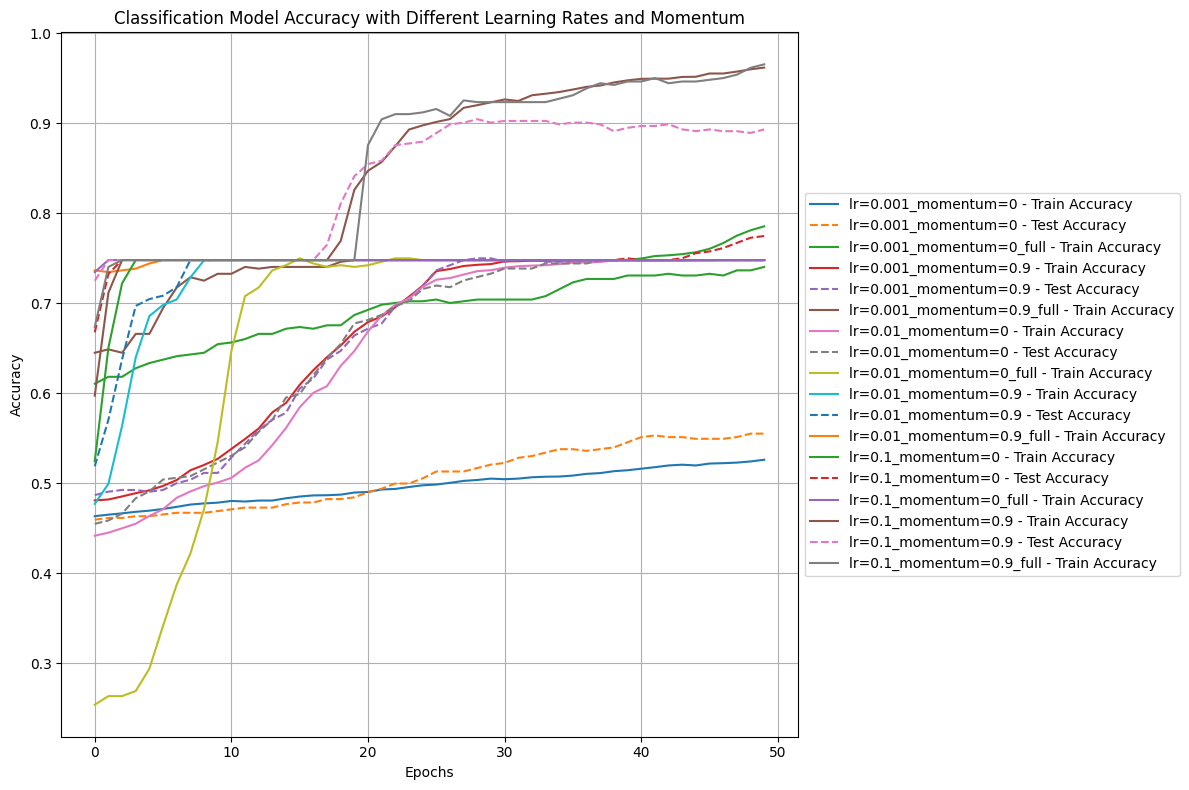

In [0]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Enhanced Classification Training with Multiple Learning Rates, Momentum, and Cross-Validation
def train_classification_with_cv(model_class, input_size, X_train, y_train, X_test, y_test, learning_rates=[1e-3, 1e-2, 1e-1], epochs=50):
    results = {}
    X_train = torch.nan_to_num(X_train, nan=0.0)
    y_train = torch.nan_to_num(y_train, nan=0.0)
    X_test = torch.nan_to_num(X_test, nan=0.0)
    y_test = torch.nan_to_num(y_test, nan=0.0)
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    
    for lr in learning_rates:
        for momentum in [0, 0.9]:  # Test with and without momentum
            fold_train_accuracies = []
            fold_test_accuracies = []
            
            # 10-fold cross-validation
            for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
                model = model_class(input_size=input_size, activations=[nn.ReLU(), nn.ReLU()])
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
                criterion = nn.CrossEntropyLoss()
                
                X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                
                fold_train_acc = []
                fold_test_acc = []
                
                for epoch in range(epochs):
                    model.train()
                    optimizer.zero_grad()
                    
                    # Forward pass
                    output = model(X_fold_train)
                    loss = criterion(output, y_fold_train)
                    
                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()
                    
                    # Calculate training accuracy
                    _, predicted = torch.max(output, 1)
                    train_accuracy = (predicted == y_fold_train).sum().item() / len(y_fold_train)
                    fold_train_acc.append(train_accuracy)
                    
                    # Validation accuracy
                    model.eval()
                    with torch.no_grad():
                        val_output = model(X_fold_val)
                        _, val_predicted = torch.max(val_output, 1)
                        val_accuracy = (val_predicted == y_fold_val).sum().item() / len(y_fold_val)
                        fold_test_acc.append(val_accuracy)
                
                fold_train_accuracies.append(fold_train_acc)
                fold_test_accuracies.append(fold_test_acc)
            
            # Average accuracy across folds for each epoch
            avg_train_acc = [sum(epoch) / len(epoch) for epoch in zip(*fold_train_accuracies)]
            avg_test_acc = [sum(epoch) / len(epoch) for epoch in zip(*fold_test_accuracies)]
            
            # Store results for plotting
            results[f'lr={lr}_momentum={momentum}'] = {
                'train_accuracy': avg_train_acc,
                'test_accuracy': avg_test_acc
            }
            
            print(f"Finished 10-fold CV with lr={lr}, momentum={momentum}")

            # Training on full dataset
            full_model = model_class(input_size=input_size, activations=[nn.ReLU(), nn.ReLU()])
            full_optimizer = optim.SGD(full_model.parameters(), lr=lr, momentum=momentum)
            
            full_train_acc = []
            for epoch in range(epochs):
                full_model.train()
                full_optimizer.zero_grad()
                
                output = full_model(X_train)
                loss = criterion(output, y_train)
                loss.backward()
                full_optimizer.step()
                
                # Calculate accuracy on full dataset
                _, predicted = torch.max(output, 1)
                train_accuracy = (predicted == y_train).sum().item() / len(y_train)
                full_train_acc.append(train_accuracy)
            
            results[f'lr={lr}_momentum={momentum}_full'] = {
                'train_accuracy': full_train_acc
            }
            
    return results

def plot_classification_results(results):
    plt.figure(figsize=(12, 8))  # Increase figure size for better readability
    for key, value in results.items():
        plt.plot(value['train_accuracy'], label=f'{key} - Train Accuracy')
        if 'test_accuracy' in value:
            plt.plot(value['test_accuracy'], linestyle='--', label=f'{key} - Test Accuracy')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Classification Model Accuracy with Different Learning Rates and Momentum')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside the plot
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

classification_results = train_classification_with_cv(
    ClassificationNN, input_size_cls, X_train_cls_torch, y_train_cls_torch, X_test_cls_torch, y_test_cls_torch, learning_rates=[1e-3, 1e-2, 1e-1], epochs=50
)

plot_classification_results(classification_results)


Training with learning rate: 1e-06 and momentum: 0
NaN values detected, filling with specified fill value.
NaN values detected, filling with specified fill value.
Training with learning rate: 1e-06 and momentum: 0.9
NaN values detected, filling with specified fill value.
NaN values detected, filling with specified fill value.
Training with learning rate: 0.0001 and momentum: 0
NaN values detected, filling with specified fill value.
NaN values detected, filling with specified fill value.
Training with learning rate: 0.0001 and momentum: 0.9
NaN values detected, filling with specified fill value.
NaN values detected, filling with specified fill value.
Training with learning rate: 0.001 and momentum: 0
NaN values detected, filling with specified fill value.
NaN values detected, filling with specified fill value.
Training with learning rate: 0.001 and momentum: 0.9
NaN values detected, filling with specified fill value.
NaN values detected, filling with specified fill value.


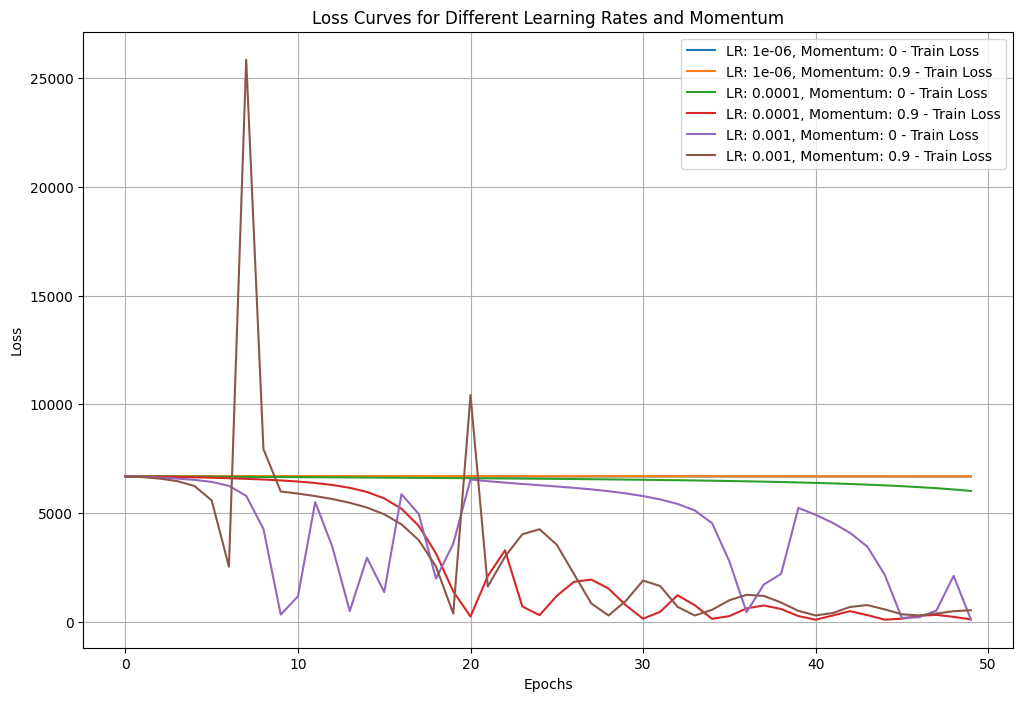

In [0]:
# Define different learning rates and momentum settings
learning_rates = [0.000001, 0.0001, 0.001]  # Three different orders of magnitude
momentum_values = [0, 0.9]  # Without and with momentum

# Store results for plotting
train_losses_all = []
test_losses_all = []
lr_momentum_combinations = []

# Define the task type to differentiate between regression and classification
task_type = "regression"  # Change to "classification" for classification task

for lr in learning_rates:
    for momentum in momentum_values:
        print(f"Training with learning rate: {lr} and momentum: {momentum}")

        # Initialize the model, criterion, and optimizer based on the task type
        if task_type == "regression":
            model = RegressionNN(input_size=X_train_reg_torch.shape[1], activations=[nn.ReLU(), nn.ReLU()])
            criterion = nn.MSELoss()
        else:
            model = ClassificationNN(input_size=X_train_cls_torch.shape[1], num_classes=2, activations=[nn.ReLU(), nn.ReLU()])
            criterion = nn.CrossEntropyLoss()
        
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        # Train and evaluate the model
        train_losses, test_losses = train_and_evaluate_with_logging(
            model, criterion, optimizer,
            X_train_reg_torch if task_type == "regression" else X_train_cls_torch,
            y_train_reg_torch if task_type == "regression" else y_train_cls_torch,
            X_test_reg_torch if task_type == "regression" else X_test_cls_torch,
            y_test_reg_torch if task_type == "regression" else y_test_cls_torch,
            task=task_type
        )

        # Store losses and parameter configuration for plotting
        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        lr_momentum_combinations.append(f"LR: {lr}, Momentum: {momentum}")

# Plot the results
plt.figure(figsize=(12, 8))
for i, label in enumerate(lr_momentum_combinations):
    plt.plot(train_losses_all[i], label=f"{label} - Train Loss")
   

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for Different Learning Rates and Momentum")
plt.legend()
plt.grid(True)
plt.show()


In [0]:
import torch
import torch.nn as nn

class ClassificationN(nn.Module):
    def __init__(self, input_size, dropout_rate=0.5):
        super(ClassificationN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  

    def forward(self, x):
        x = torch.tanh(self.fc1(x))  # Apply tanh activation
        x = self.dropout(x)
        x = torch.tanh(self.fc2(x))  # Apply tanh activation
        x = self.fc3(x)  # No activation in the output layer for classification
        return x
    
class RegressionN(nn.Module):
    def __init__(self, input_size, dropout_rate=0.5):
        super(RegressionN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))  # Apply ReLU activation
        x = self.fc3(x)  # No activation in the output layer for regression
        return x


Finished 10-fold CV with lr=0.001, dropout=0.2
Finished 10-fold CV with lr=0.001, dropout=0.5


/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished 10-fold CV with lr=0.001, dropout=0.7


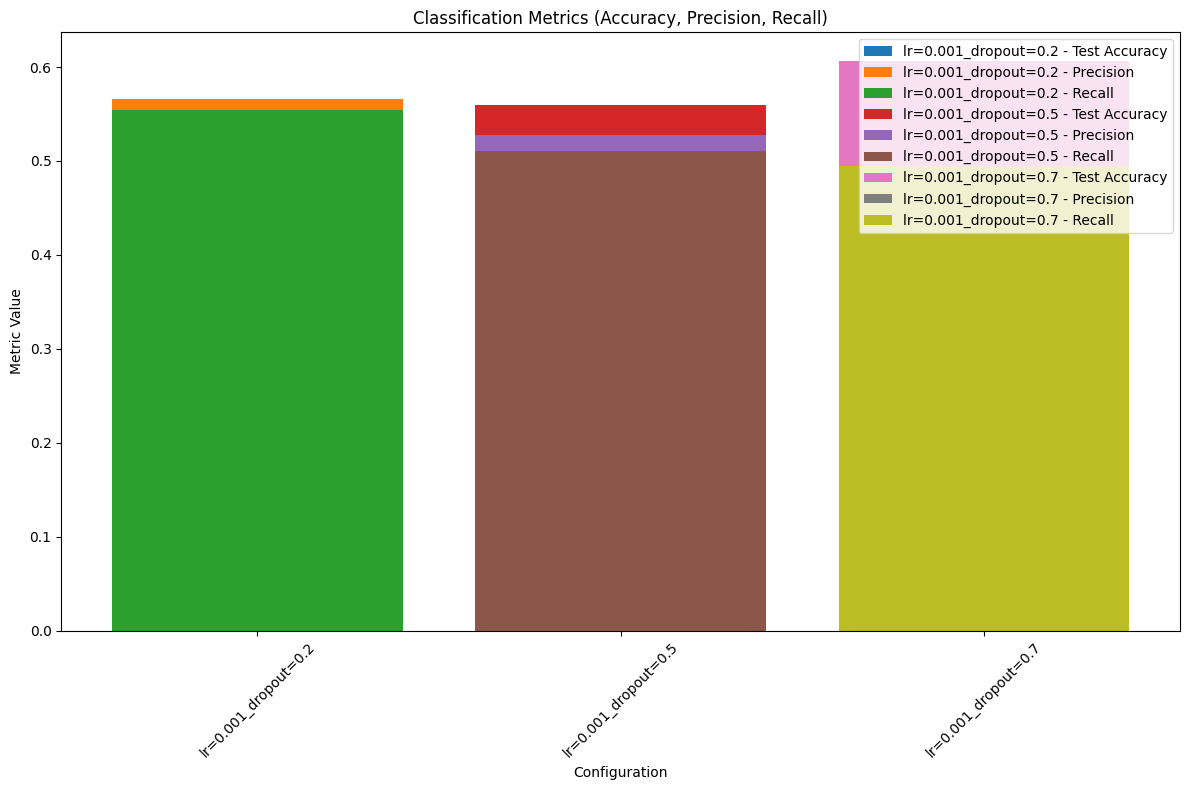

Finished 10-fold CV with lr=0.001, dropout=0.2
Finished 10-fold CV with lr=0.001, dropout=0.5
Finished 10-fold CV with lr=0.001, dropout=0.7


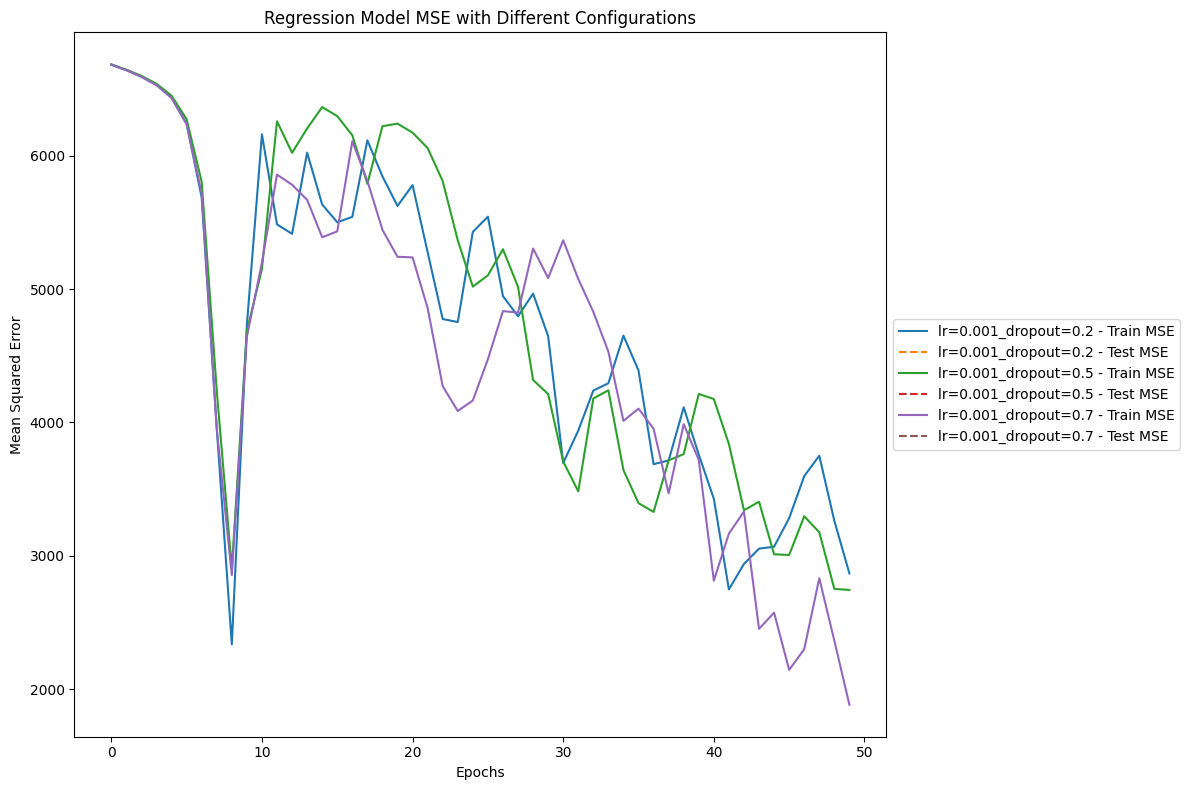

In [0]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Enhanced Classification Training with Multiple Dropout Rates
def train_classification_with_cv(model_class, input_size, X_train, y_train, learning_rates=[0.001], epochs=50, dropout_rates=[0.2, 0.5, 0.7]):
    results = {}
    X_train = torch.nan_to_num(X_train, nan=0.0)
    y_train = torch.nan_to_num(y_train, nan=0.0)

    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    for lr in learning_rates:
        for dropout_rate in dropout_rates:
            fold_train_accuracies = []
            fold_test_accuracies = []
            fold_test_precisions = []
            fold_test_recalls = []

            # 10-fold cross-validation
            for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
                model = model_class(input_size=input_size, dropout_rate=dropout_rate)
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.09)
                criterion = nn.CrossEntropyLoss()

                X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

                fold_train_acc = []
                fold_test_acc = []

                for epoch in range(epochs):
                    model.train()
                    optimizer.zero_grad()

                    # Forward pass
                    output = model(X_fold_train)
                    loss = criterion(output, y_fold_train)

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    # Calculate training accuracy
                    _, predicted = torch.max(output, 1)
                    train_accuracy = (predicted == y_fold_train).sum().item() / len(y_fold_train)
                    fold_train_acc.append(train_accuracy)

                # Validation performance
                model.eval()
                with torch.no_grad():
                    val_output = model(X_fold_val)
                    _, val_predicted = torch.max(val_output, 1)
                    val_accuracy = (val_predicted == y_fold_val).sum().item() / len(y_fold_val)
                    fold_test_acc.append(val_accuracy)

                    # Precision and Recall
                    val_precision = precision_score(y_fold_val.cpu(), val_predicted.cpu(), average='macro')
                    val_recall = recall_score(y_fold_val.cpu(), val_predicted.cpu(), average='macro')
                    fold_test_precisions.append(val_precision)
                    fold_test_recalls.append(val_recall)

                fold_train_accuracies.append(fold_train_acc)
                fold_test_accuracies.append(val_accuracy)

            # Average metrics across folds
            avg_train_acc = [sum(epoch) / len(epoch) for epoch in zip(*fold_train_accuracies)]
            avg_test_acc = sum(fold_test_accuracies) / len(fold_test_accuracies)
            avg_precision = sum(fold_test_precisions) / len(fold_test_precisions)
            avg_recall = sum(fold_test_recalls) / len(fold_test_recalls)

            # Store results for plotting
            results[f'lr={lr}_dropout={dropout_rate}'] = {
                'train_accuracy': avg_train_acc,
                'test_accuracy': avg_test_acc,
                'precision': avg_precision,
                'recall': avg_recall
            }

            print(f"Finished 10-fold CV with lr={lr}, dropout={dropout_rate}")

    return results

# Enhanced Regression Training with Multiple Dropout Rates
def train_regression_with_cv(model_class, input_size, X_train, y_train, learning_rates=[0.001], epochs=50, dropout_rates=[0.2, 0.5, 0.7]):
    results = {}
    X_train = torch.nan_to_num(X_train, nan=0.0)
    y_train = torch.nan_to_num(y_train, nan=0.0)

    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    for lr in learning_rates:
        for dropout_rate in dropout_rates:
            fold_train_mse = []
            fold_test_mse = []

            # 10-fold cross-validation
            for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
                model = model_class(input_size=input_size, dropout_rate=dropout_rate)
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.09)
                criterion = nn.MSELoss()

                X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

                fold_train_loss = []

                for epoch in range(epochs):
                    model.train()
                    optimizer.zero_grad()

                    # Forward pass
                    output = model(X_fold_train)
                    loss = criterion(output, y_fold_train)

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    fold_train_loss.append(loss.item())

                # Validation performance
                model.eval()
                with torch.no_grad():
                    val_output = model(X_fold_val)
                    mse = mean_squared_error(y_fold_val.cpu().numpy(), val_output.cpu().numpy())
                    fold_test_mse.append(mse)

                fold_train_mse.append(fold_train_loss)

            # Average MSE across folds for each epoch
            avg_train_mse = [sum(epoch) / len(epoch) for epoch in zip(*fold_train_mse)]
            avg_test_mse = sum(fold_test_mse) / len(fold_test_mse)

            # Store results for plotting
            results[f'lr={lr}_dropout={dropout_rate}'] = {
                'train_mse': avg_train_mse,
                'test_mse': avg_test_mse
            }

            print(f"Finished 10-fold CV with lr={lr}, dropout={dropout_rate}")

    return results

# Plot Classification Results
def plot_classification_results(results):
    plt.figure(figsize=(12, 8))
    for key, value in results.items():
        plt.bar(key, value['test_accuracy'], label=f'{key} - Test Accuracy')
        plt.bar(key, value['precision'], label=f'{key} - Precision')
        plt.bar(key, value['recall'], label=f'{key} - Recall')

    plt.ylabel('Metric Value')
    plt.xlabel('Configuration')
    plt.title('Classification Metrics (Accuracy, Precision, Recall)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot Regression Results
def plot_regression_results(results):
    plt.figure(figsize=(12, 8))
    for key, value in results.items():
        plt.plot(value['train_mse'], label=f'{key} - Train MSE')
        plt.plot(value['test_mse'], label=f'{key} - Test MSE', linestyle='--')

    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Regression Model MSE with Different Configurations')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# Run classification experiment with dropout
classification_results = train_classification_with_cv(
    ClassificationN, input_size_cls, X_train_cls_torch, y_train_cls_torch, learning_rates=[0.001], epochs=50, dropout_rates=[0.2, 0.5, 0.7]
)
plot_classification_results(classification_results)

# Run regression experiment with dropout
regression_results = train_regression_with_cv(
    RegressionN, input_size_reg, X_train_reg_torch, y_train_reg_torch, learning_rates=[0.001], epochs=50, dropout_rates=[0.2, 0.5, 0.7]
)
plot_regression_results(regression_results)

Optimized Model Accuracy on Test Set: 0.65
Default Model Accuracy on Test Set: 0.55


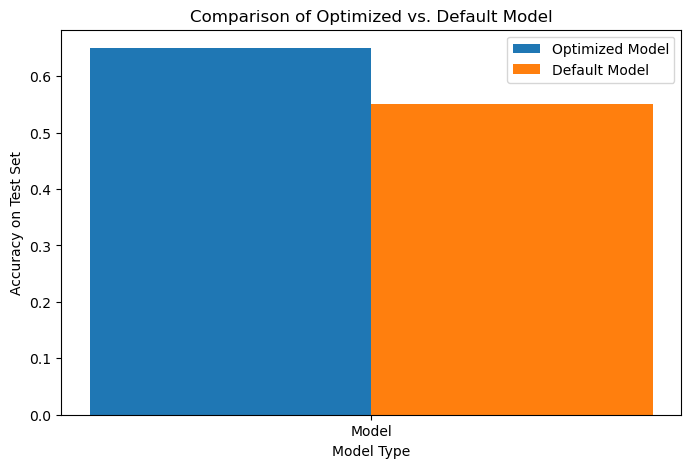

In [0]:
optimized_regression_model = RegressionN(input_size=X_train_reg_torch.shape[1], dropout_rate=0.7)


/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification

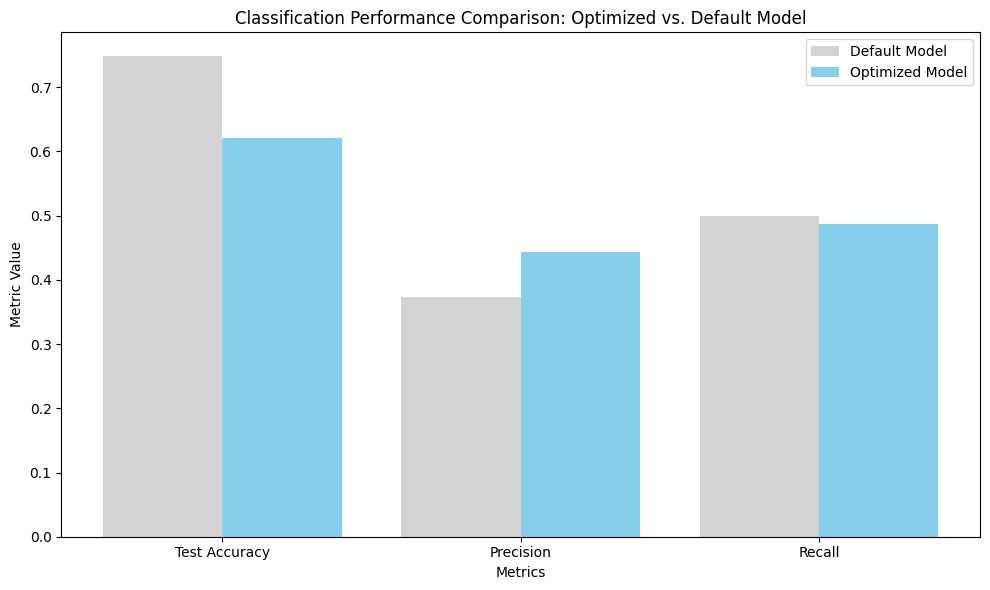

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, accuracy_score, mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Define a simple classification model with dropout
class SimpleClassificationModel(nn.Module):
    def __init__(self, input_size, dropout_rate=0.5):
        super(SimpleClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # For binary classification
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Classification model training with cross-validation and dropout rates
def train_classification_with_cv(model_class, input_size, X_train, y_train, learning_rate=0.001, epochs=50, dropout_rate=0.7):
    results = {}
    X_train = torch.nan_to_num(X_train, nan=0.0)
    y_train = torch.nan_to_num(y_train, nan=0.0)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    fold_train_accuracies, fold_test_accuracies, fold_test_precisions, fold_test_recalls = [], [], [], []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        model = model_class(input_size=input_size, dropout_rate=dropout_rate)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.09)
        criterion = nn.CrossEntropyLoss()
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        fold_train_acc, fold_test_acc = [], []
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_fold_train)
            loss = criterion(output, y_fold_train)
            loss.backward()
            optimizer.step()
            
            # Training accuracy
            _, predicted = torch.max(output, 1)
            train_accuracy = (predicted == y_fold_train).sum().item() / len(y_fold_train)
            fold_train_acc.append(train_accuracy)
        
        # Validation performance
        model.eval()
        with torch.no_grad():
            val_output = model(X_fold_val)
            _, val_predicted = torch.max(val_output, 1)
            val_accuracy = (val_predicted == y_fold_val).sum().item() / len(y_fold_val)
            fold_test_acc.append(val_accuracy)
            
            # Precision and Recall
            val_precision = precision_score(y_fold_val.cpu(), val_predicted.cpu(), average='macro')
            val_recall = recall_score(y_fold_val.cpu(), val_predicted.cpu(), average='macro')
            fold_test_precisions.append(val_precision)
            fold_test_recalls.append(val_recall)

        fold_train_accuracies.append(fold_train_acc)
        fold_test_accuracies.append(val_accuracy)

    # Average metrics across folds
    avg_train_acc = [sum(epoch) / len(epoch) for epoch in zip(*fold_train_accuracies)]
    avg_test_acc = sum(fold_test_accuracies) / len(fold_test_accuracies)
    avg_precision = sum(fold_test_precisions) / len(fold_test_precisions)
    avg_recall = sum(fold_test_recalls) / len(fold_test_recalls)

    # Store results for plotting
    results[f'lr={learning_rate}_dropout={dropout_rate}'] = {
        'train_accuracy': avg_train_acc,
        'test_accuracy': avg_test_acc,
        'precision': avg_precision,
        'recall': avg_recall
    }

    return results

# Instantiate and train default and optimized models with cross-validation
input_size_cls = X_train_cls_torch.shape[1]  # Define input size for classification model
default_classification_results = train_classification_with_cv(SimpleClassificationModel, input_size_cls, X_train_cls_torch, y_train_cls_torch, learning_rate=0.01, dropout_rate=0.5)
optimized_classification_results = train_classification_with_cv(ClassificationN, input_size_cls, X_train_cls_torch, y_train_cls_torch, learning_rate=0.001, dropout_rate=0.7)

# Plotting function to compare default and optimized results
def plot_classification_comparison(optimized_results, default_results):
    # Extract configurations and metrics
    optimized_config = list(optimized_results.keys())[0]
    default_config = list(default_results.keys())[0]
    
    # Retrieve test accuracy, precision, and recall for optimized and default models
    optimized_accuracy = optimized_results[optimized_config]['test_accuracy']
    optimized_precision = optimized_results[optimized_config]['precision']
    optimized_recall = optimized_results[optimized_config]['recall']
    
    default_accuracy = default_results[default_config]['test_accuracy']
    default_precision = default_results[default_config]['precision']
    default_recall = default_results[default_config]['recall']
    
    # Set up bar plot for comparison
    metrics = ['Test Accuracy', 'Precision', 'Recall']
    optimized_values = [optimized_accuracy, optimized_precision, optimized_recall]
    default_values = [default_accuracy, default_precision, default_recall]

    # Plotting
    x = range(len(metrics))
    plt.figure(figsize=(10, 6))
    plt.bar(x, default_values, width=0.4, label='Default Model', color='lightgray')
    plt.bar([p + 0.4 for p in x], optimized_values, width=0.4, label='Optimized Model', color='skyblue')
    
    # Labels and ticks
    plt.xlabel("Metrics")
    plt.ylabel("Metric Value")
    plt.title("Classification Performance Comparison: Optimized vs. Default Model")
    plt.xticks([p + 0.2 for p in x], metrics)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot comparison of the classification results from the default and optimized models
plot_classification_comparison(optimized_classification_results, default_classification_results)
